# 深層生成モデル（VAE・GAN）

- どんなことができるのか、手を動かしてみてみましょう

# VAE (Variational Auto Encoder)

- VAEは深層生成モデルの一種で、与えられたデータと似たようなデータを幅広く生成することができます。
  - VAE全体はエンコードして小さい次元のベクトルに圧縮した後にデコードするような、入力を再構成するNNモデルとなっています。
  - エンコード先はが正規分布に近づくようなlossを入れることで、コンパクトに圧縮されたベクトルzにエンコードすることができ、またzを少し変化させると様々な画像をデコードすることができます。


<img src="https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.amazonaws.com%2F0%2F50670%2F9ea8d9b7-dc55-2e58-31c3-7d303f4dae8d.png?ixlib=rb-4.0.0&auto=format&gif-q=60&q=75&w=1400&fit=max&s=d6d1ca8aa21ea10e80f2ee774446038c" width="640">

- 出典: [Variational Autoencoder徹底解説
](https://qiita.com/kenmatsu4/items/b029d697e9995d93aa24)

- 目的関数

$$
Loss = 再構成誤差 + zのはみだし具合(KLダイバージェンス)
$$

- 時間がかかるのでepoch数を減らして実行してみます

In [1]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image


parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=8, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args("".split())

args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, args.epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                    'sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.595764
Train Epoch: 1 [1280/60000 (2%)]	Loss: 287.982056
Train Epoch: 1 [2560/60000 (4%)]	Loss: 242.801651
Train Epoch: 1 [3840/60000 (6%)]	Loss: 213.623199
Train Epoch: 1 [5120/60000 (9%)]	Loss: 216.030853
Train Epoch: 1 [6400/60000 (11%)]	Loss: 216.303207
Train Epoch: 1 [7680/60000 (13%)]	Loss: 203.971207
Train Epoch: 1 [8960/60000 (15%)]	Loss: 197.527985
Train Epoch: 1 [10240/60000 (17%)]	Loss: 199.671753
Train Epoch: 1 [11520/60000 (19%)]	Loss: 192.269043
Train Epoch: 1 [12800/60000 (21%)]	Loss: 186.938980
Train Epoch: 1 [14080/60000 (23%)]	Loss: 179.695877
Train Epoch: 1 [15360/60000 (26%)]	Loss: 168.194870
Train Epoch: 1 [16640/60000 (28%)]	Loss: 165.249542
Train Epoch: 1 [17920/60000 (30%)]	Loss: 166.312332
Train Epoch: 1 [19200/60000 (32%)]	Loss: 162.762482
Train Epoch: 1 [20480/60000 (34%)]	Loss: 167.461792
Train Epoch: 1 [21760/60000 (36%)]	Loss: 154.407196
Train Epoch: 1 [23040/60000 (38%)]	Loss: 153.276062
Train Epoch: 1 [24320/60000 

In [2]:
N = 5
data, _ = iter(test_loader).next()
data = data[:N].to(device)

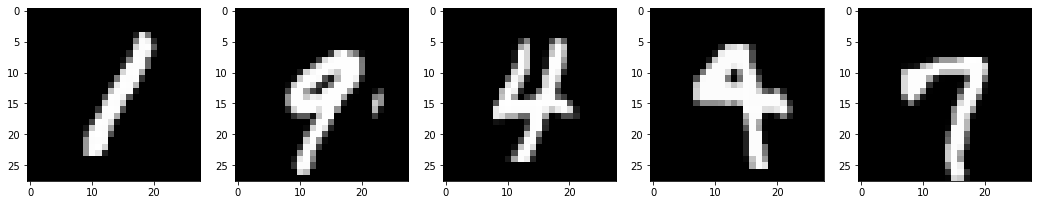

In [3]:
import matplotlib.pyplot as plt

data_np = data.detach().cpu().numpy()

plt.figure(figsize=(18,18))
for i in range(N):
  plt.subplot(1,N,i+1); plt.imshow(data_np[i].squeeze(), "gray")
plt.show()

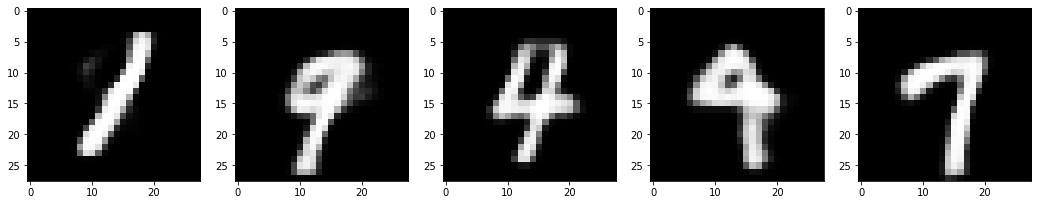

In [4]:
recon_batch, mu, logvar = model(data)
recon_batch = recon_batch.view(N, 28, 28).detach().cpu().numpy()

plt.figure(figsize=(18,18))
for i in range(N):
  plt.subplot(1,N,i+1); plt.imshow(recon_batch[i], "gray")
plt.show()

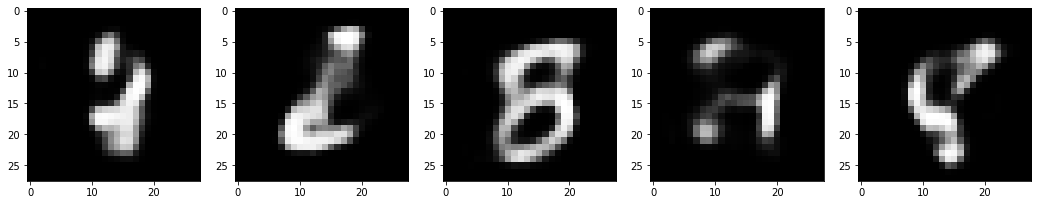

In [5]:
N = 5

sample = torch.randn(N, 20).to(device)
sample = model.decode(sample)

sample = sample.view(N, 28, 28).detach().cpu().numpy()


plt.figure(figsize=(18,18))
for i in range(N):
  plt.subplot(1,N,i+1); plt.imshow(sample[i], "gray")
plt.show()

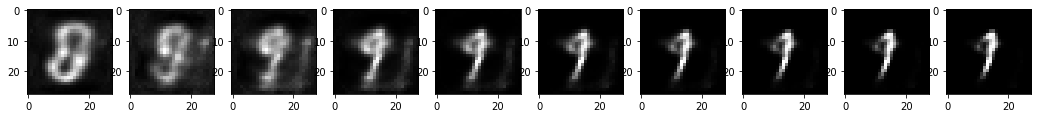

In [6]:
a = torch.randn(20).to(device)
b = torch.randn(20).to(device)

N = 10
sample = torch.stack([r*a/float(N) + (1.-r)*b/float(N) for r in range(N)])
sample = model.decode(sample)
sample = sample.view(N, 28, 28).detach().cpu().numpy()

plt.figure(figsize=(18,18))
for i in range(N):
  plt.subplot(1,N,i+1); plt.imshow(sample[i], "gray")
plt.show()

# GAN (Generative Adversarial Networks)


- GANは深層生成モデルの一種で、与えられたデータと遜色ない本物のような画像を作ることができます。
  - GANの全体は生成器(G:Generator)と識別器(D:Disctiminator)の二つからなっており、生成器は識別器をだませるように、識別器は本物のデータと生成されたデータを見分けられるように、いたちごっこのような学習を行います。

<img src="https://www.bigdata-navi.com/aidrops/wp-content/uploads/2020/03/1.svg" width="640">

出典: https://www.bigdata-navi.com/aidrops/2519/


- 目的関数

  - 1つの式に表すと以下のようになります(ミニマックス問題)
<img src="https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.amazonaws.com%2F0%2F233208%2F78f624e8-cc53-c7a3-178c-0551048bef30.jpeg?ixlib=rb-4.0.0&auto=format&gif-q=60&q=75&w=1400&fit=max&s=e003da075ce59572516d53df27ea3ef8" width="640">

  - 識別器の目的関数 (D=1: 本物と判断, D=0: 偽物と判断)
<img src="https://www.bigdata-navi.com/aidrops/wp-content/uploads/2020/03/img_18.png" width="640">

    - 識別器は本物は本物、偽物は偽物と識別できるようにする

  - 生成器の目的関数
<img src="https://www.bigdata-navi.com/aidrops/wp-content/uploads/2020/03/img_19.png" width="400">

    - 生成器は、本物だと識別されるようにする

- ref: http://aidiary.hatenablog.com/entry/20180304/1520172429

- 時間がかかるのでepoch数を減らして実行してみます

In [7]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(62, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, 7, 7)
        x = self.deconv(x)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)
    
    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * 7 * 7)
        x = self.fc(x)
        return x

# Generatorのサイズテスト
G = Generator()
input = torch.rand((32, 62))
out = G(input)
print(out.size())
torch.Size([32, 1, 28, 28])

# Discriminatorのサイズテスト
D = Discriminator()
input = torch.rand((32, 1, 28, 28))
out = D(input)
print(out.size())
torch.Size([32, 1])

# hyperparameters
batch_size = 128
lr = 0.0002
z_dim = 62
num_epochs = 10  # 25
sample_num = 16
log_dir = './'

# initialize network
G = Generator().to(device)
D = Discriminator().to(device)

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# loss
criterion = nn.BCELoss()

# load dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

def train(D, G, criterion, D_optimizer, G_optimizer, data_loader):
    # 訓練モードへ
    D.train()
    G.train()

    # 本物のラベルは1
    y_real = torch.ones(batch_size, 1)
    # 偽物のラベルは0
    y_fake = torch.zeros(batch_size, 1)
    
    y_real = y_real.to(device)
    y_fake = y_fake.to(device)

    D_running_loss = 0
    G_running_loss = 0
    for batch_idx, (real_images, _) in enumerate(tqdm(data_loader)):
        z = torch.rand((batch_size, z_dim))
        real_images, z = real_images.to(device), z.to(device)

        # Discriminatorの更新
        D_optimizer.zero_grad()

        # Discriminatorにとって本物画像の認識結果は1（本物）に近いほどよい
        # E[log(D(x))]
        D_real = D(real_images)
        D_real_loss = criterion(D_real, y_real)

        # DiscriminatorにとってGeneratorが生成した偽物画像の認識結果は0（偽物）に近いほどよい
        # E[log(1 - D(G(z)))]
        # fake_imagesを通じて勾配がGに伝わらないようにdetach()して止める
        fake_images = G(z)
        D_fake = D(fake_images.detach())
        D_fake_loss = criterion(D_fake, y_fake)

        # 2つのlossの和を最小化する
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()

        # Generatorの更新
        z = torch.rand((batch_size, z_dim))
        z = z.to(device)

        G_optimizer.zero_grad()

        # GeneratorにとってGeneratorが生成した画像の認識結果は1（本物）に近いほどよい
        # E[log(D(G(z)))
        fake_images = G(z)
        D_fake = D(fake_images)
        G_loss = criterion(D_fake, y_real)
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
    
    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)
    
    return D_running_loss, G_running_loss

def generate(epoch, G, log_dir='logs'):
    G.eval()
    
    os.makedirs(log_dir, exist_ok=True)

    # 生成のもとになる乱数を生成
    sample_z = torch.rand((64, z_dim))
    sample_z = sample_z.to(device)
    
    # Generatorでサンプル生成
    with torch.no_grad():
        samples = G(sample_z).to('cpu')
    save_image(samples, os.path.join(log_dir, 'epoch_%03d.png' % (epoch)))

history = {}
history['D_loss'] = []
history['G_loss'] = []
for epoch in range(num_epochs):
    D_loss, G_loss = train(D, G, criterion, D_optimizer, G_optimizer, data_loader)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # 特定のエポックでGeneratorから画像を生成してモデルも保存
    if epoch == 0 or epoch == 9 or epoch == 24:
        generate(epoch + 1, G, log_dir)
        torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
        torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))

# 学習履歴を保存
with open(os.path.join(log_dir, 'history.pkl'), 'wb') as f:
    pickle.dump(history, f)

cuda
torch.Size([32, 1, 28, 28])
torch.Size([32, 1])


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 1, D_loss: 0.8255 G_loss: 1.3022


  1%|          | 4/468 [00:00<00:14, 32.97it/s]

epoch 2, D_loss: 1.0237 G_loss: 1.1171


  1%|          | 4/468 [00:00<00:13, 33.16it/s]

epoch 3, D_loss: 1.0485 G_loss: 1.0855


  1%|          | 4/468 [00:00<00:13, 33.36it/s]

epoch 4, D_loss: 1.0479 G_loss: 1.0947


  1%|          | 4/468 [00:00<00:14, 32.89it/s]

epoch 5, D_loss: 1.0379 G_loss: 1.1054


  1%|          | 4/468 [00:00<00:13, 34.56it/s]

epoch 6, D_loss: 1.0215 G_loss: 1.1376


  1%|          | 4/468 [00:00<00:13, 33.88it/s]

epoch 7, D_loss: 0.9936 G_loss: 1.1692


  1%|          | 4/468 [00:00<00:13, 33.27it/s]

epoch 8, D_loss: 0.9674 G_loss: 1.2082


  1%|          | 4/468 [00:00<00:14, 33.02it/s]

epoch 9, D_loss: 0.9452 G_loss: 1.2532


100%|██████████| 468/468 [00:13<00:00, 33.63it/s]


epoch 10, D_loss: 0.9130 G_loss: 1.2955


In [8]:
sample_z = torch.rand((64, z_dim))
sample_z = sample_z.to(device)

# Generatorでサンプル生成
with torch.no_grad():
    samples = G(sample_z).to('cpu')

samples = samples.view(64, 28, 28).detach().cpu().numpy()

In [9]:
print(samples.shape)

(64, 28, 28)


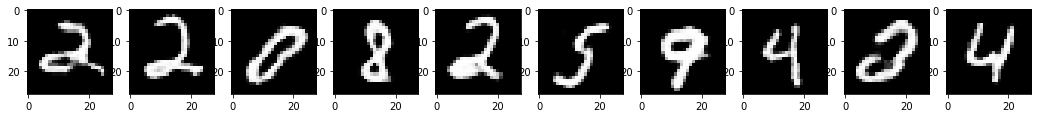

In [10]:
plt.figure(figsize=(18,18))
samples = samples[:N]
for i in range(N):
  plt.subplot(1,N,i+1); plt.imshow(samples[i], "gray")
plt.show()